In [426]:
import requests
import bs4
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from pandas import DataFrame

In [503]:
#first step, download all comments of specific movie from metacritic website by using beautifulsoup
def comments_download(url,header):
    try:
        r = requests.get(url,headers=header)
        r.encoding = 'UTF-8'
        r.raise_for_status()
        r.encoding = r.apparent_encoding
        #html_content = BeautifulSoup(r.text,'html.parser')
        html_content = BeautifulSoup(r.text,'lxml')
        return(html_content)
    except:
        print('download failed!')
    #parser downloaded html content
#url = 'https://www.metacritic.com/movie/shang-chi-and-the-legend-of-the-ten-rings?ftag=MCD-06-10aaa1c'
url = 'https://www.metacritic.com/movie/shang-chi-and-the-legend-of-the-ten-rings/user-reviews'
#url = 'https://www.metacritic.com/movie/shang-chi-and-the-legend-of-the-ten-rings/user-reviews?page=1'
#url = 'https://www.metacritic.com/movie/shang-chi-and-the-legend-of-the-ten-rings/user-reviews?page=2'
header_info = {'user-agent':'Mozilla/5.0'}
html_contents = comments_download(url,header_info)

In [506]:
def single_page(html_contents):
    #get the comment of html_contents, object type is beautifulsoup
    results = []
    for tags in html_contents.find_all('div','review pad_top1'):
        for child in tags.descendants:
            if(child.name=='div'):
                if child.find('span','author') != None:
                    author = child.find('span','author').get_text()
                if child.find('span','date') != None:
                    date = child.find('span','date').get_text()
                if child.find('span','yes_count')!= None:
                    yes_count = child.find('span','yes_count').get_text()
                if child['class'][0] == 'metascore_w':
                    score = str(child.string)
            if(len(list(tags.find('div','review_body').descendants)))>4:
                if isinstance(child,bs4.Tag) and isinstance(child.find('span'),bs4.Tag) and len(child['class'])>1:
                    if child['class'][1]=='inline_collapsed':
                        comment = child.get_text().replace('…','').replace('Expand','')
                    else:
                        if child.find('div','review_body') != None:
                            comment = child.find('div','review_body').get_text().strip()
            else:
                if isinstance(child,bs4.Tag):
                    comment_tmp = child.find('div','review_body')
                    if comment_tmp != None:
                        comment = comment_tmp.get_text().strip()
        #single_result = author+'\t'+date+'\t'+yes_count+'\t'+score+'\t'+comment
        single_result = [author,date,yes_count,score,comment]
        results.append(single_result)
    result_df = pd.DataFrame(results)
    result_df.columns = ['user','date','upvote','score','comment']
    return(result_df)
#single_df = single_page(html_contents)

In [507]:
def total_pages(page_num):
    i=0
    page_comment = []
    while i < page_num:
        url = 'https://www.metacritic.com/movie/shang-chi-and-the-legend-of-the-ten-rings/user-reviews?page='+str(i)
        i+=1
        #print(url)
        single_html_contents = comments_download(url,header_info)
        single_page_df = single_page(single_html_contents)
        page_comment.append(single_page_df)
    total_df = pd.concat(page_comment)
    return(total_df)
total_result_df = total_pages(3)

In [508]:
total_result_df.to_csv('total_comment_shang_chi.csv',encoding='utf-8')

In [509]:
total_result_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 0 to 42
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user     243 non-null    object
 1   date     243 non-null    object
 2   upvote   243 non-null    object
 3   score    243 non-null    object
 4   comment  243 non-null    object
dtypes: object(5)
memory usage: 11.4+ KB


In [510]:
total_result_df.head()

,user,date,upvote,score,comment
0,cuadropalooza,"Sep 4, 2021",37,8,The MCU has finally reached a point where we h...
1,Anastasyah,"Sep 5, 2021",35,9,That's one of the best marvel movie! I love th...
2,d0vla11,"Sep 10, 2021",27,7,I had low expectations for this one and was ac...
3,AquaArcher,"Sep 10, 2021",27,8,This has the best fight choreography in an MCU...
4,J-will,"Sep 25, 2021",24,10,Outstanding Marvel movie! Visual and actions i...


In [463]:
import pandas_bokeh
pandas_bokeh.output_notebook()
pd.set_option('plotting.backend', 'pandas_bokeh')
from bokeh.transform import linear_cmap
from bokeh.palettes import Spectral
from bokeh.io import curdoc

Loading BokehJS ...

In [511]:
df_test = total_result_df

In [512]:
df_test['time'] = pd.to_datetime(df_test.date).dt.date

In [513]:
df_test.head()

,user,date,upvote,score,comment,time
0,cuadropalooza,"Sep 4, 2021",37,8,The MCU has finally reached a point where we h...,2021-09-04
1,Anastasyah,"Sep 5, 2021",35,9,That's one of the best marvel movie! I love th...,2021-09-05
2,d0vla11,"Sep 10, 2021",27,7,I had low expectations for this one and was ac...,2021-09-10
3,AquaArcher,"Sep 10, 2021",27,8,This has the best fight choreography in an MCU...,2021-09-10
4,J-will,"Sep 25, 2021",24,10,Outstanding Marvel movie! Visual and actions i...,2021-09-25


In [520]:
date_comment_num = df_test.groupby('time').nunique()#.to_frame('comment_num')
#print(date_comment_num)
#print(date_comment_num.shape)
date_comment_num.index = date_comment_num.index.astype('string')
y = date_comment_num['comment']
mapper = linear_cmap(field_name='comment', palette=Spectral[11] ,low=min(y) ,high=max(y))
date_bar = date_comment_num.plot_bokeh.bar(
    ylabel="comment number", 
    title="comment number by date", 
    color=mapper,
    alpha=0.8,
    legend=False    
)

In [524]:
df_test['comment_len'] = df_test['comment'].str.len()
df_test['comment_len'] = df_test['comment_len'].fillna(0).astype(int)
contentlen_hist = df_test.plot_bokeh.hist(
    y='comment_len',
    ylabel="comment_num", 
    bins=np.linspace(0, 100, 26),
    vertical_xlabel=True,
    hovertool=False,
    title="comment len bar",
    color='red',
    line_color="white",
    legend=False,
#     normed=100,
    )

In [525]:
from wordcloud import WordCloud

In [526]:
df_test.head()

,user,date,upvote,score,comment,time,comment_len
0,cuadropalooza,"Sep 4, 2021",37,8,The MCU has finally reached a point where we h...,1,949
1,Anastasyah,"Sep 5, 2021",35,9,That's one of the best marvel movie! I love th...,1,557
2,d0vla11,"Sep 10, 2021",27,7,I had low expectations for this one and was ac...,1,595
3,AquaArcher,"Sep 10, 2021",27,8,This has the best fight choreography in an MCU...,1,612
4,J-will,"Sep 25, 2021",24,10,Outstanding Marvel movie! Visual and actions i...,1,911


In [532]:
all_comments = ' '.join(df_test['comment'].to_list())

In [533]:
wc = WordCloud()
wc.generate(all_comments)

(-0.5, 399.5, 199.5, -0.5)

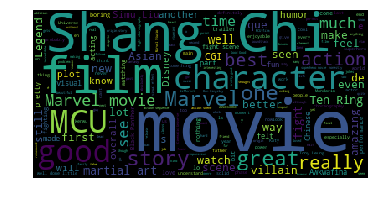

In [534]:
import matplotlib.pyplot as plt
plt.imshow(wc)
plt.axis("off")

In [423]:
type(html_contents)

bs4.BeautifulSoup

In [314]:
num=0
for tags in html_contents.find_all('div',{'class':'review pad_top1'}):
    #print(tags)
    num+=1
    if num ==5:
        #print(tags)
        print('test')
        #print(tags.find('div','review_body').contents)
        #for child in tags.find('div','review_body').descendants:
            #comment = ' '.join(child.find_all(text=True))
            #print(comment)
        #    print(child)
        #    print(child.name)
        print(len(list(tags.find('div','review_body').descendants)))
    if num == 6:
        print('short comment.....')
        print(len(list(tags.find('div','review_body').descendants)))
        #for child in tags.find('div','review_body').descendants:
            #print(child)
            #if child.name =='span' and len(child['class']):
            #print(type(child))
            #print(child.name)
            #if child.find('span')!=None:
                
        #print(tags.find('div','review_body').contents)

test
12
short comment.....
4


In [215]:
for child in html_contents.find_all('div','review pad_top1'):
    for tmp in child.descendants:
        print(tmp)



<div class="left fl">
<div class="metascore_w user large movie positive indiv">8</div>
</div>


<div class="metascore_w user large movie positive indiv">8</div>
8




<div class="right fl">
<div class="title pad_btm_half"><span class="author"><a href="/user/cuadropalooza">cuadropalooza</a></span><span class="date">Sep  4, 2021</span></div>
<div class="summary">
<div class="review_body">
<span class="inline_expand_collapse inline_collapsed" id="review_blurb_14257869"><span class="blurb blurb_collapsed">The MCU has finally reached a point where we have seen a lot of weird stuffs, So they can throw something really crazy at us and we will just accept it as normal. That's what I love about this movie, it takes you to a wild journey where</span><span class="blurb blurb_expanded">The MCU has finally reached a point where we have seen a lot of weird stuffs, So they can throw something really crazy at us and we will just accept it as normal. That's what I love about this movie, it takes you 



<div class="msg"></div>






<span class="all_reviews"><a href="/user/Marbrockstar">All this user's reviews</a></span>
<a href="/user/Marbrockstar">All this user's reviews</a>
All this user's reviews
 
<div class="clr"></div>






<div class="clr"></div>




<div class="left fl">
<div class="metascore_w user large movie positive indiv perfect">10</div>
</div>


<div class="metascore_w user large movie positive indiv perfect">10</div>
10




<div class="right fl">
<div class="title pad_btm_half"><span class="author"><a href="/user/capxwinter">capxwinter</a></span><span class="date">Sep  4, 2021</span></div>
<div class="summary">
<div class="review_body">
<span>i've never seen something so beautiful. incredible story, even greater characters, a lot of family drama, stunning fighting scenes and majestic animals.<br/><br/>one of marvel's greatest so far<br/><br/>ps: simu liu and awkwafina are THE duo</span>
</div>
</div>
<div class="interactions pad_top1">
<span class="helpful_wrapper"

<div class="metascore_w user large movie positive indiv">7</div>
7




<div class="right fl">
<div class="title pad_btm_half"><span class="author"><a href="/user/Ronedaz">Ronedaz</a></span><span class="date">Sep 10, 2021</span></div>
<div class="summary">
<div class="review_body">
<span class="inline_expand_collapse inline_collapsed" id="review_blurb_14276321"><span class="blurb blurb_collapsed">Although I'm not the biggest Marvel fan, I always go to the movies to see the popular new releases. So I decided to go and see Shang-Chi last week with some friends. I was not disappointed at all! Of course , it's kind of different if you're</span><span class="blurb blurb_expanded">Although I'm not the biggest Marvel fan, I always go to the movies to see the popular new releases. So I decided to go and see Shang-Chi last week with some friends. I was not disappointed at all! Of course , it's kind of different if you're going to compare it to some other Marvel movies, but it's really interesting



<div class="interactions pad_top1">
<span class="helpful_wrapper">
<div class="helpful" data-mcrefid="14259425" data-mcreftype="230">
<div class="thumbs">
<span class="text"><span class="yes_count">32</span> of <span class="total_count">34</span> users found this helpful</span><span class="thumb_up"><i aria-hidden="true" class="fa fa-thumbs-up"></i><span class="count">32</span></span><span class="thumb_down"><i aria-hidden="true" class="fa fa-thumbs-down"></i><span class="count">2</span></span> <span class="progress ">
<i class="fa fa-spinner"></i>
</span>
</div>
<div class="msg"></div>
</div>
</span>
<span class="all_reviews"><a href="/user/Diptanshu">All this user's reviews</a></span> <div class="clr"></div>
</div>


<span class="helpful_wrapper">
<div class="helpful" data-mcrefid="14259425" data-mcreftype="230">
<div class="thumbs">
<span class="text"><span class="yes_count">32</span> of <span class="total_count">34</span> users found this helpful</span><span class="thumb_up"><i a

Entertaining if somewhat long superhero origin story. Both leads are very entertaining and their interactions with each other and the outside world, and are a highlight of the movie. As are the many fight scenes. Visually an impressive movie.
<span class="blurb blurb_expanded">Entertaining if somewhat long superhero origin story. Both leads are very entertaining and their interactions with each other and the outside world, and are a highlight of the movie. As are the many fight scenes. Visually an impressive movie. Not much wrong with it as a very entertaining popcorn affair. Despite the simplicity of some of the characters and the inevitable plot holes that accompany superhero worlds.</span>
Entertaining if somewhat long superhero origin story. Both leads are very entertaining and their interactions with each other and the outside world, and are a highlight of the movie. As are the many fight scenes. Visually an impressive movie. Not much wrong with it as a very entertaining popcorn a